In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [2]:
image_dir = Path('C:/Users/sm160/OneDrive - Amity University/Desktop/amity/sem8/dataset/gaussian_filtered_images/gaussian_filtered_images')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [3]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(5)

,Filepath,Label
0,C:\Users\sm160\OneDrive - Amity University\Des...,Moderate
1,C:\Users\sm160\OneDrive - Amity University\Des...,Moderate
2,C:\Users\sm160\OneDrive - Amity University\Des...,Mild
3,C:\Users\sm160\OneDrive - Amity University\Des...,Moderate
4,C:\Users\sm160\OneDrive - Amity University\Des...,No_DR


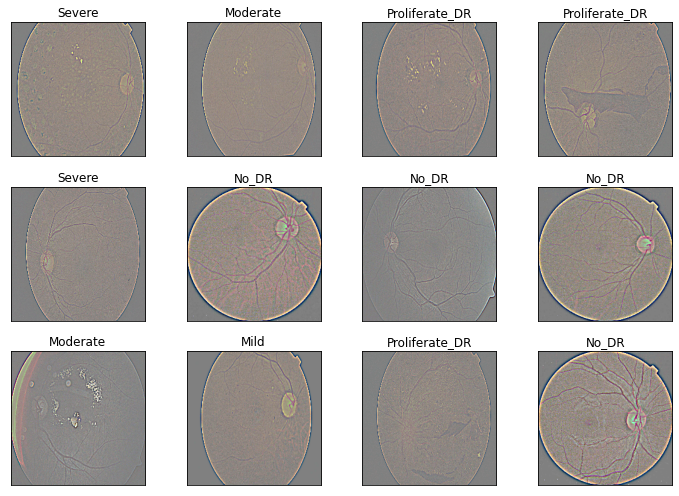

In [4]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

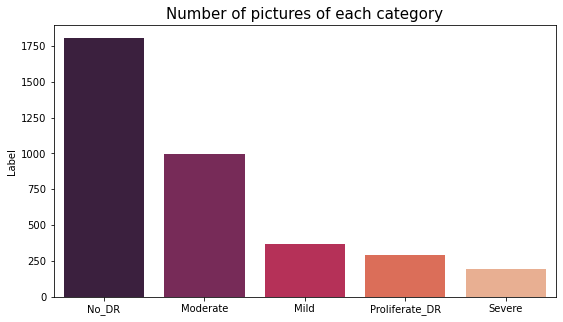

No_DR             1805
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: Label, dtype: int64


In [14]:
# Display the number of pictures of each category
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()
print(vc)

In [4]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )
    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [5]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [6]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [7]:
#Dictionary with the models
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():
    
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)
    # Save the duration, the train_accuracy and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]
    
    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.


93/93 [==============================] - 236s 2s/step - loss: 0.8243 - accuracy: 0.7087 - val_loss: 0.6436 - val_accuracy: 0.7781
DenseNet121          trained in 237.24 sec


In [9]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, 
                          models[name]['train_accuracy'][-1],
                          models[name]['val_acc'][-1], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results
model

{'model': <keras.engine.functional.Functional at 0x1677f41bd00>,
 'perf': 183.7,
 'val_acc': [0.766],
 'train_accuracy': [0.7003]}

In [8]:
# Load the pretained model
pretrained_model = tf.keras.applications.DenseNet121(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [9]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [10]:
def lr_rate(epoch,lr):
    if epoch<10:
        lr=0.0001
        return lr
    elif epoch<=15:
        lr=0.0005
        return lr
    elif epoch<=30:
        lr=0.0001
        return lr
    else:
        lr=lr*(epoch/(1+epoch))
        return lr
lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_rate)

In [13]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[lr_callback],
    verbose=1
)

Epoch 1/50
93/93 [==============================] - 188s 2s/step - loss: 1.0739 - accuracy: 0.6389 - val_loss: 0.8809 - val_accuracy: 0.6839 - lr: 1.0000e-04
Epoch 2/50
93/93 [==============================] - 180s 2s/step - loss: 0.8108 - accuracy: 0.7181 - val_loss: 0.7672 - val_accuracy: 0.7356 - lr: 1.0000e-04
Epoch 3/50
93/93 [==============================] - 180s 2s/step - loss: 0.7296 - accuracy: 0.7417 - val_loss: 0.7135 - val_accuracy: 0.7416 - lr: 1.0000e-04
Epoch 4/50
93/93 [==============================] - 173s 2s/step - loss: 0.6817 - accuracy: 0.7583 - val_loss: 0.6930 - val_accuracy: 0.7295 - lr: 1.0000e-04
Epoch 5/50
93/93 [==============================] - 180s 2s/step - loss: 0.6522 - accuracy: 0.7637 - val_loss: 0.6899 - val_accuracy: 0.7295 - lr: 1.0000e-04
Epoch 6/50
93/93 [==============================] - 178s 2s/step - loss: 0.6314 - accuracy: 0.7704 - val_loss: 0.6519 - val_accuracy: 0.7538 - lr: 1.0000e-04
Epoch 7/50
93/93 [==============================] - 

In [17]:
sheet1=pd.DataFrame(history.history)[['accuracy','val_accuracy']]
acc_sheet=sheet1*100
with pd.ExcelWriter('C:/Users/sm160/OneDrive - Amity University/Desktop/output2.xlsx') as writer:  
    acc_sheet.to_excel(writer, sheet_name='Sheet1')
print(acc_sheet)

     accuracy  val_accuracy
0   61.968982     69.300914
1   71.948755     72.644377
2   74.409980     72.644377
3   75.118005     70.820671
4   75.758600     74.164134
5   76.399189     73.860180
6   77.039784     74.164134
7   77.140933     75.987840
8   77.983814     73.556232
9   78.186107     77.203649
10  77.545518     76.899695
11  78.995281     75.379938
12  79.534727     78.115499
13  79.973030     77.507597
14  81.287932     77.203649
15  81.557655     78.115499
16  83.378285     81.155014
17  83.546865     76.899695
18  84.356034     79.635257
19  84.187460     78.723407
20  84.524614     80.243158
21  84.929198     78.115499
22  85.266352     79.939210
23  84.996629     79.331309
24  85.401213     78.723407
25  85.704654     77.203649
26  86.142951     77.507597
27  85.772085     77.811551
28  85.839516     79.939210
29  86.008090     78.723407
30  86.480105     79.331309
31  86.176670     79.635257
32  86.446393     79.635257
33  87.086987     79.027355
34  87.289280     79

In [18]:
sheet2=pd.DataFrame(history.history)[['loss','val_loss']]
print(sheet2)
with pd.ExcelWriter('C:/Users/sm160/OneDrive - Amity University/Desktop/output3.xlsx') as writer:  
    sheet2.to_excel(writer, sheet_name='Sheet2')

        loss  val_loss
0   1.088857  0.969643
1   0.812521  0.833335
2   0.724442  0.777370
3   0.675920  0.779790
4   0.648929  0.704126
5   0.626189  0.689336
6   0.609131  0.698338
7   0.594285  0.668993
8   0.581402  0.687172
9   0.569942  0.640990
10  0.611746  0.660261
11  0.563286  0.652420
12  0.554152  0.643340
13  0.535838  0.603981
14  0.495000  0.611080
15  0.494518  0.594937
16  0.435856  0.574504
17  0.425531  0.618916
18  0.422026  0.568867
19  0.414939  0.588857
20  0.409052  0.574960
21  0.407086  0.592180
22  0.400567  0.565569
23  0.403355  0.571362
24  0.395150  0.609635
25  0.389996  0.597492
26  0.384384  0.627580
27  0.380471  0.591998
28  0.380032  0.567253
29  0.374160  0.583248
30  0.369808  0.577737
31  0.363508  0.588120
32  0.362176  0.564936
33  0.360527  0.580532
34  0.354093  0.573785
35  0.350352  0.596178
36  0.345257  0.579684
37  0.342768  0.580639
38  0.342203  0.570015
39  0.333740  0.603832
40  0.332508  0.604110
41  0.329464  0.606212
42  0.32483

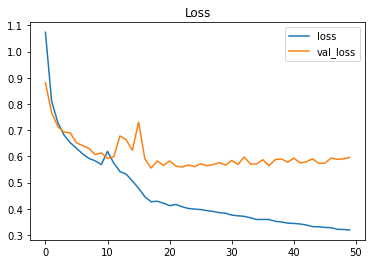

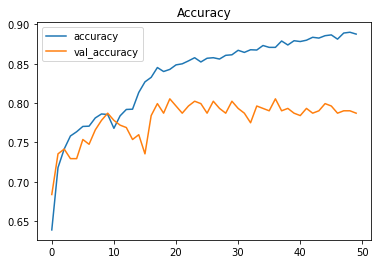

In [15]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [16]:
for name, v in models.items():
    models_result.append([ name, 
                          models[name]['train_accuracy'][-1],
                          models[name]['val_acc'][-1], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])

In [17]:
results = model.evaluate(test_images, verbose=0)

In [18]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

12/12 [==============================] - 22s 2s/step
The first 5 predictions: ['Moderate', 'Mild', 'Moderate', 'Moderate', 'No_DR']


In [19]:
print((pred))
print(type(test_df["Label"]))

['Moderate', 'Mild', 'Moderate', 'Moderate', 'No_DR', 'No_DR', 'Moderate', 'No_DR', 'Moderate', 'No_DR', 'No_DR', 'Moderate', 'No_DR', 'No_DR', 'Moderate', 'Moderate', 'Moderate', 'No_DR', 'No_DR', 'No_DR', 'Moderate', 'No_DR', 'Mild', 'No_DR', 'No_DR', 'Moderate', 'No_DR', 'No_DR', 'No_DR', 'No_DR', 'No_DR', 'Moderate', 'Moderate', 'No_DR', 'Moderate', 'No_DR', 'Severe', 'No_DR', 'No_DR', 'No_DR', 'Moderate', 'No_DR', 'Moderate', 'No_DR', 'No_DR', 'No_DR', 'Moderate', 'Moderate', 'Moderate', 'No_DR', 'No_DR', 'Moderate', 'Mild', 'Moderate', 'Mild', 'Moderate', 'Proliferate_DR', 'No_DR', 'No_DR', 'No_DR', 'Mild', 'Proliferate_DR', 'Moderate', 'Moderate', 'Severe', 'No_DR', 'Moderate', 'No_DR', 'No_DR', 'No_DR', 'Moderate', 'Moderate', 'Severe', 'Moderate', 'Moderate', 'Moderate', 'No_DR', 'Moderate', 'Moderate', 'Moderate', 'No_DR', 'No_DR', 'Moderate', 'No_DR', 'No_DR', 'No_DR', 'No_DR', 'Moderate', 'No_DR', 'No_DR', 'No_DR', 'No_DR', 'Moderate', 'Mild', 'Mild', 'No_DR', 'No_DR', 'Mod

In [20]:
llist = test_df["Label"].tolist()
print(type(llist))

<class 'list'>


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

[[92, 29, 0, 2, 3], [6, 76, 0, 4, 0], [13, 0, 22, 1, 5], [2, 1, 7, 65, 0], [1, 3, 4, 0, 31]]


<Figure size 1080x720 with 0 Axes>

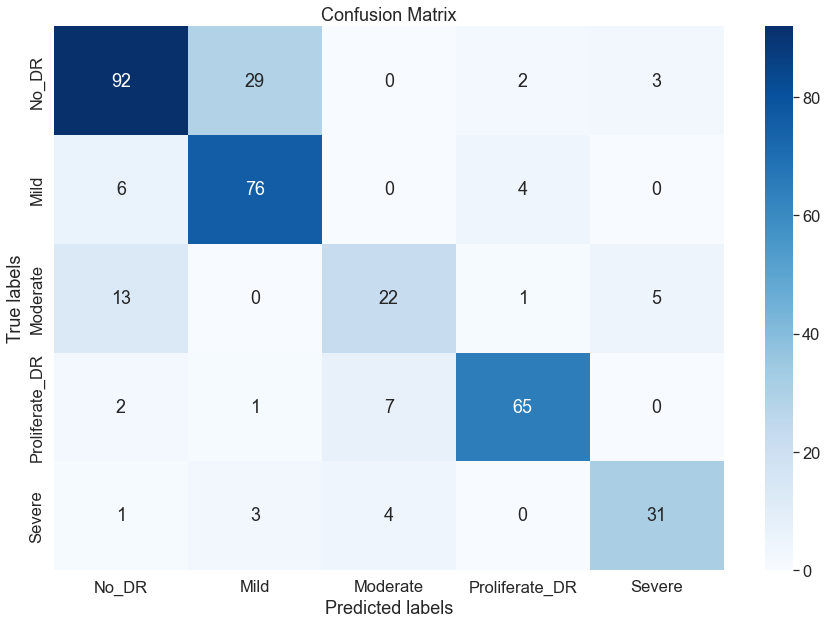

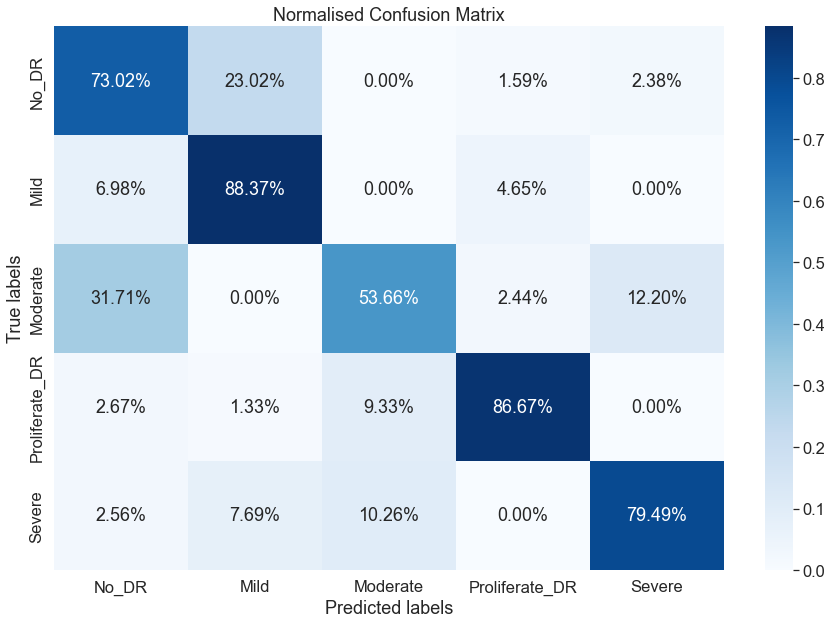

In [2]:
#DENSEENET
# sns.heatmap(cm, annot=True,cmap="Blues",ax=ax)
plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)

cm=[[92,29,0,2,3],[6,76,0,4,0],[13,0,22,1,5],[2,1,7,65,0],[1,3,4,0,31]]
print(cm)
plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)

ax= plt.subplot()
sns.heatmap(cm, annot=True,cmap="Blues",ax=ax)
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

ax.xaxis.set_ticklabels(["No_DR", "Mild", "Moderate","Proliferate_DR","Severe"]); ax.yaxis.set_ticklabels(["No_DR", "Mild", "Moderate","Proliferate_DR","Severe"]);

#--------------------------
plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)

ax= plt.subplot()

confusion_matrix=np.array([[92,29,0,2,3],[6,76,0,4,0],[13,0,22,1,5],[2,1,7,65,0],[1,3,4,0,31]])
cm_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, cmap="Blues",fmt='.2%')

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Normalised Confusion Matrix');

ax.xaxis.set_ticklabels(["No_DR", "Mild", "Moderate","Proliferate_DR","Severe"]); ax.yaxis.set_ticklabels(["No_DR", "Mild", "Moderate","Proliferate_DR","Severe"]);


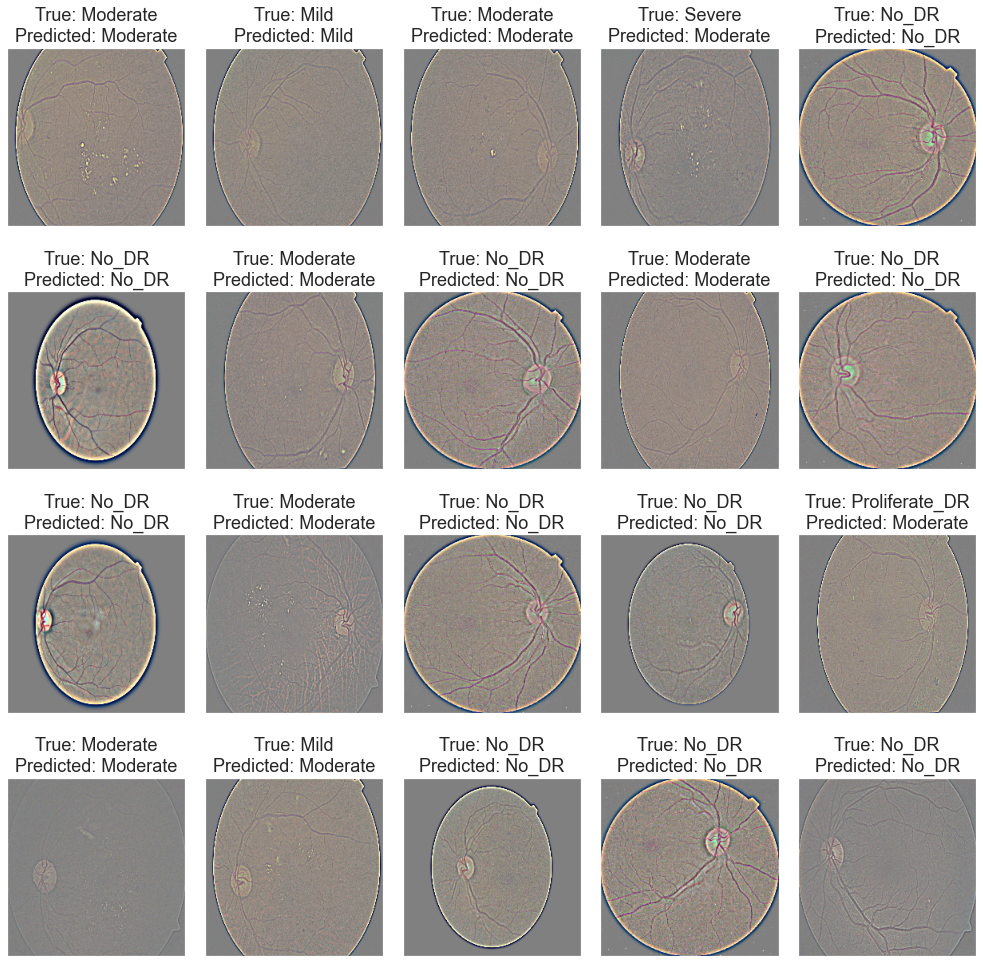

In [27]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(14, 14),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()